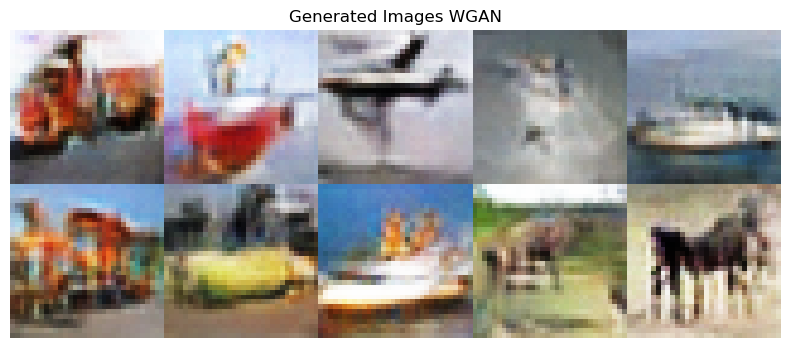

In [11]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image

# Generator Model
class Generator(nn.Module):
    def __init__(self, noise_dim, condition_dim, img_channels):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(noise_dim + condition_dim, 2 * 2 * 256, bias=False),
            nn.BatchNorm1d(2 * 2 * 256),
            nn.ReLU(inplace=True)
        )

        self.conv_blocks = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 128, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 128, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, img_channels, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, condition):
        merged = torch.cat((noise, condition), dim=1)
        out = self.fc(merged)
        out = out.view(out.size(0), 256, 2, 2)
        out = self.conv_blocks(out)
        return out

# Parameters
NOISE_DIM = 100
CONDITION_DIM = 10
IMAGE_CHANNELS = 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the trained model
generator = Generator(NOISE_DIM, CONDITION_DIM, IMAGE_CHANNELS).to(device)
generator.load_state_dict(torch.load("models/generator_epoch_500.pth"))
generator.eval()

# Generate and save images
def generate_and_show_images(generator, num_images=10, save_path="generated_images_wgan.png"):
    noise = torch.randn(num_images, NOISE_DIM, device=device)
    random_labels = torch.randint(0, CONDITION_DIM, (num_images,), device=device)
    conditions = nn.functional.one_hot(random_labels, num_classes=CONDITION_DIM).float()
    with torch.no_grad():
        fake_images = generator(noise, conditions)
    fake_images = (fake_images + 1) / 2  # Scale to [0, 1] for visualization

    # Display and save the images using Matplotlib
    grid_img = make_grid(fake_images.cpu(), nrow=5, padding=0)  # Set padding to 0
    np_grid = grid_img.permute(1, 2, 0).numpy()
    plt.figure(figsize=(10, 4))  # Set figure size to 10 inches by 4 inches
    plt.imshow(np_grid)
    plt.axis('off')
    plt.title('Generated Images WGAN')

    # Save the displayed image with desired size
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()

# Generate, save, and display images
generate_and_show_images(generator, save_path="generated_images_wgan.png")

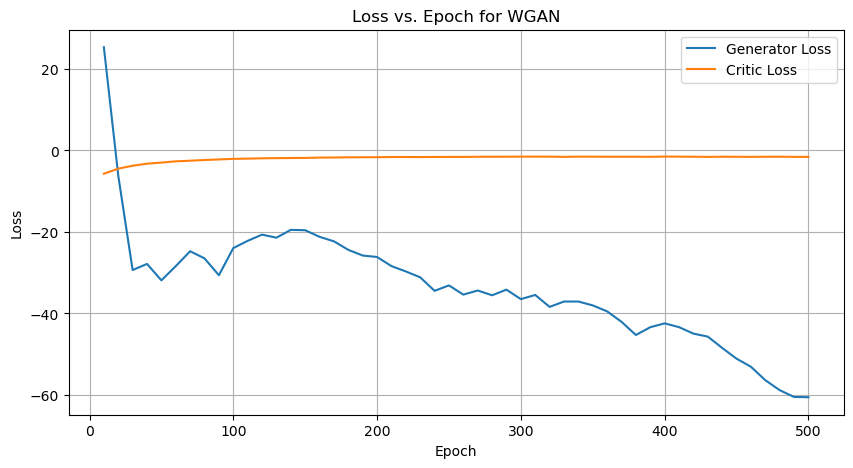

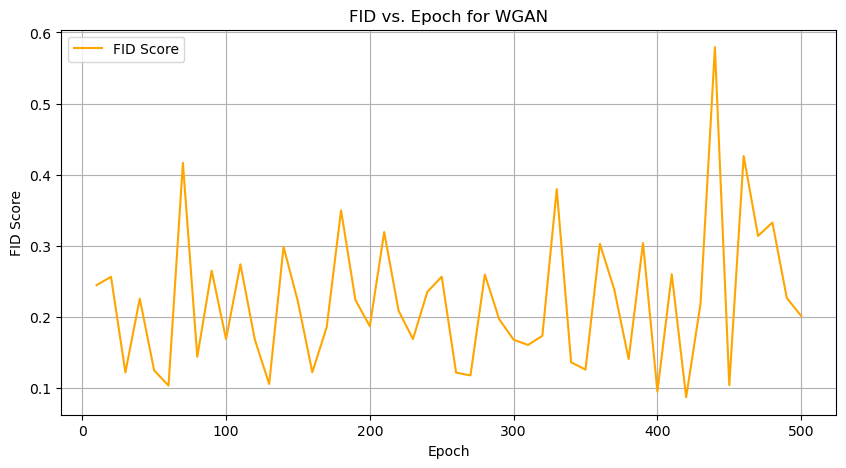

In [9]:
import pandas as pd

# Load log file
log_file = "logs/training_log.csv"
df = pd.read_csv(log_file)

# Ensure that 'Epoch' column is sorted
df = df.sort_values('Epoch')

# Plot Generator Loss and Critic Loss vs. Epoch
plt.figure(figsize=(10, 5))
plt.plot(df["Epoch"], df["Generator Loss"], label="Generator Loss")
plt.plot(df["Epoch"], df["Critic Loss"], label="Critic Loss")
plt.title("Loss vs. Epoch for WGAN")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("loss_vs_epoch_WGAN.png")
plt.show()

# Plot FID vs. Epoch
plt.figure(figsize=(10, 5))
plt.plot(df["Epoch"], df["FID Score"], label="FID Score", color="orange")
plt.title("FID vs. Epoch for WGAN")
plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.legend()
plt.grid(True)
plt.savefig("fid_vs_epoch_WGAN.png")
plt.show()
